
# 一 使用sklearn数据集训练逻辑回归模型；



#1. 数据加载与探索

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

# 设置字体为系统中已有的字体（如 Arial 或其他中文字体）
plt.rcParams['font.family'] = 'DejaVu Sans'  # 替换为系统中存在的字体
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

#  2. 数据加载与探索

In [6]:
iris = datasets.load_iris()
X, y = iris.data, iris.target

# 数据概览
print("特征名称:", iris.feature_names)
print("类别名称:", iris.target_names)
print("\n样本数量:", X.shape[0])
print("特征数量:", X.shape[1])
print("类别分布:", np.bincount(y))

特征名称: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
类别名称: ['setosa' 'versicolor' 'virginica']

样本数量: 150
特征数量: 4
类别分布: [50 50 50]


# 可视化特征分布

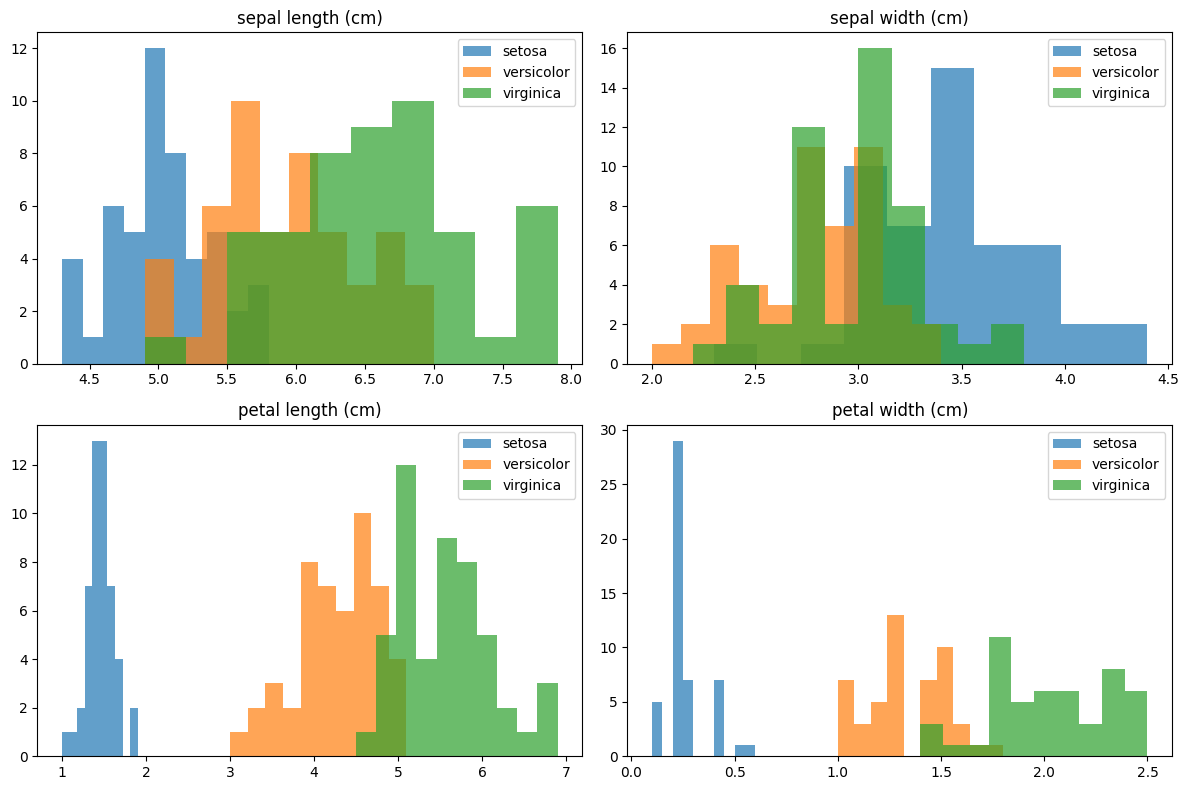

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, (name, ax) in enumerate(zip(iris.feature_names, axes.flatten())):
    for class_idx in range(3):
        ax.hist(X[y == class_idx, i], alpha=0.7, label=iris.target_names[class_idx])
    ax.set_title(name)
    ax.legend()
plt.tight_layout()

# 3. 数据预处理与建模

In [10]:
# 划分训练集/测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 创建建模Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),          # 标准化处理
    ('poly', PolynomialFeatures(degree=2)), # 二次多项式特征扩展
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        solver='saga',  # 支持L1/L2正则化
        multi_class='multinomial'
    ))
])

# 超参数搜索空间
param_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': np.logspace(-3, 3, 7),  # 正则化强度
}

# 网格搜索配置
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)


# 4. 模型训练与调优

In [11]:
# 执行网格搜索
grid_search.fit(X_train, y_train)

# 显示最佳参数
print("最佳参数组合:", grid_search.best_params_)
print("交叉验证最佳准确率:", grid_search.best_score_.round(3))

最佳参数组合: {'clf__C': 0.1, 'clf__penalty': 'l2'}
交叉验证最佳准确率: 0.967


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# 5. 模型评估

测试集评估报告:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.75      0.90      0.82        10
   virginica       0.88      0.70      0.78        10

    accuracy                           0.87        30
   macro avg       0.88      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



Text(0.5, 1.0, 'ConfusionMatrixDisplay')

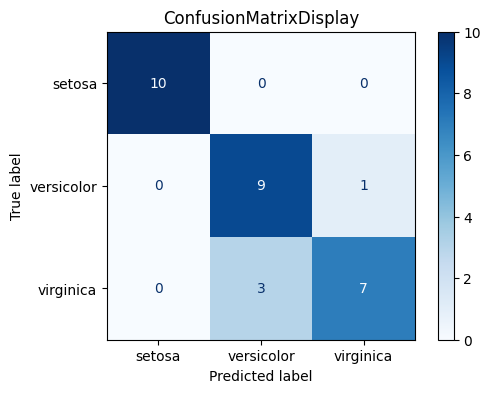

In [22]:
# 在测试集上评估
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 分类报告
print("测试集评估报告:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# 混淆矩阵可视化
fig, ax = plt.subplots(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=iris.target_names
)
disp.plot(ax=ax, cmap='Blues')
plt.title("ConfusionMatrixDisplay")

#6. **决策边界可视化**

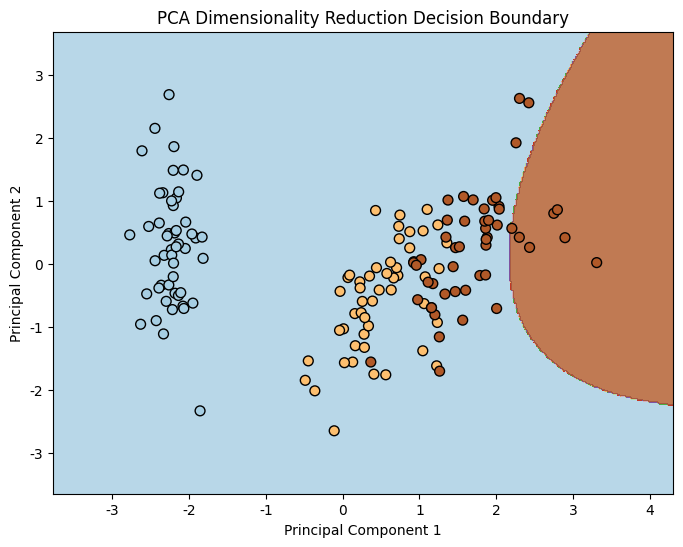

In [24]:
# PCA降维可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

# 自定义决策边界绘制函数
def plot_decision_surface(model, X, y):
    # 创建网格点
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # 生成预测
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # 绘制图形
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='black', s=50, cmap=plt.cm.Paired)
    plt.xlabel('Principal Component 1')  # 主成分1 → Principal Component 1
    plt.ylabel('Principal Component 2')  # 主成分2 → Principal Component 2
    plt.title("PCA Dimensionality Reduction Decision Boundary")  # PCA降维决策边界 → PCA Dimensionality Reduction Decision Boundary

# 可视化结果
plt.figure(figsize=(8,6))
plot_decision_surface(best_model, X_pca, y)
plt.show()

# 7. 特征重要性分析

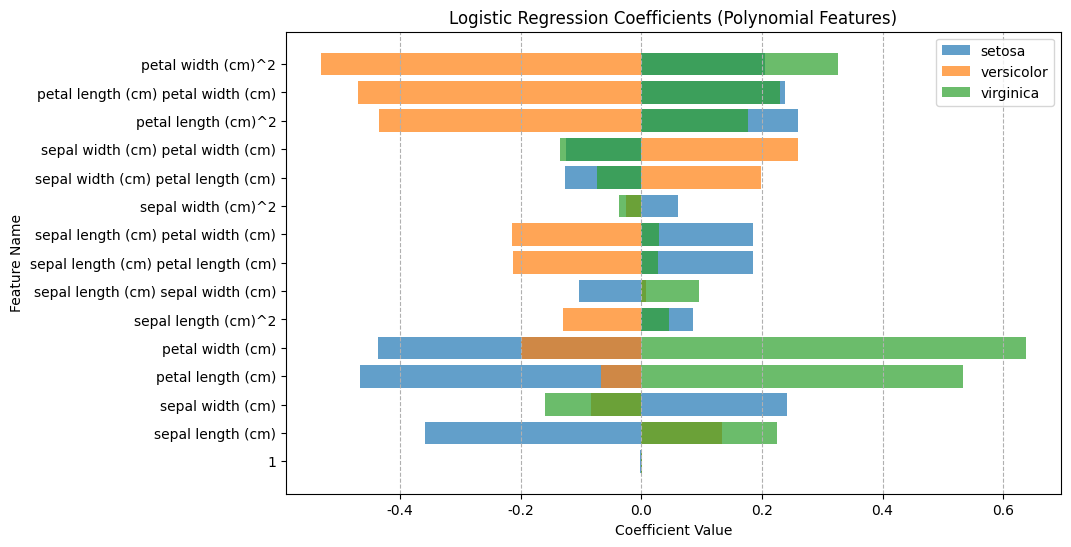

In [26]:
# 提取特征系数
poly_feature_names = best_model.named_steps['poly'].get_feature_names_out(
    input_features=iris.feature_names
)
coefficients = best_model.named_steps['clf'].coef_

# 可视化特征系数
plt.figure(figsize=(10, 6))
for i, class_coef in enumerate(coefficients):
    plt.barh(range(len(class_coef)), class_coef, alpha=0.7, label=iris.target_names[i])

plt.yticks(range(len(poly_feature_names)), poly_feature_names)
plt.title("Logistic Regression Coefficients (Polynomial Features)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature Name")
plt.legend()
plt.grid(True, axis='x', linestyle='--')
plt.show()

# 8. 模型部署准备

In [27]:
# 保存最终模型
from joblib import dump
dump(best_model, 'iris_logreg_model.joblib')

# 模型元数据
print("模型信息:")
print(f"输入特征: {iris.feature_names}")
print(f"目标类别: {iris.target_names.tolist()}")
print(f"模型准确率: {grid_search.best_score_:.3f} (交叉验证)")

模型信息:
输入特征: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
目标类别: ['setosa', 'versicolor', 'virginica']
模型准确率: 0.967 (交叉验证)


#二 调整学习率，样本数据拆分比率，观察训练结果；
#1. 数据拆分比例对比实验

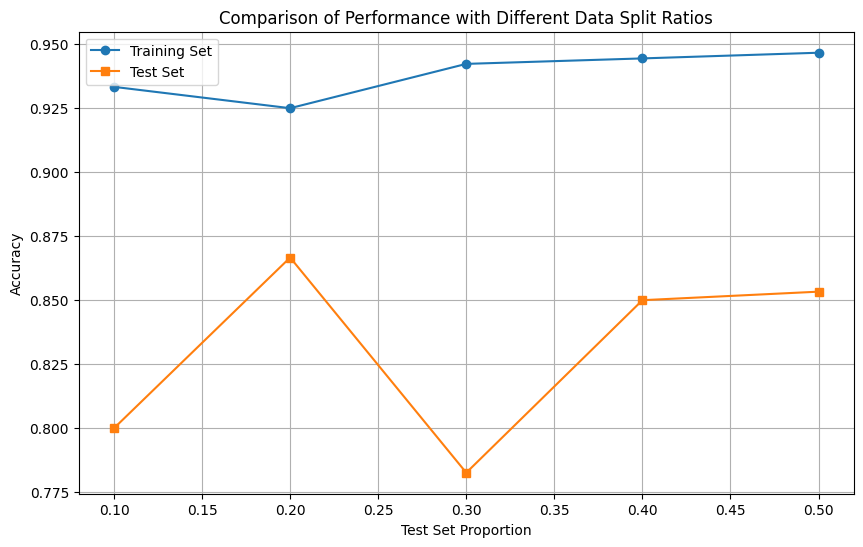

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from joblib import dump

# 加载数据
X, y = datasets.load_iris(return_X_y=True)

# 测试不同拆分比例
test_sizes = np.linspace(0.1, 0.5, 5)
train_scores, test_scores = [], []

for size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=size, stratify=y, random_state=42
    )

    # 创建包含标准化的管道
    model = make_pipeline(
        StandardScaler(),
        SGDClassifier(
            loss='log_loss',
            learning_rate='constant',
            eta0=0.01,
            max_iter=1000,
            random_state=42
        )
    )

    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(test_sizes, train_scores, 'o-', label="Training Set")
plt.plot(test_sizes, test_scores, 's-', label="Test Set")
plt.xlabel('Test Set Proportion')
plt.ylabel('Accuracy')
plt.title('Comparison of Performance with Different Data Split Ratios')
plt.legend()
plt.grid(True)
plt.show()


# 2. 学习率调参实验

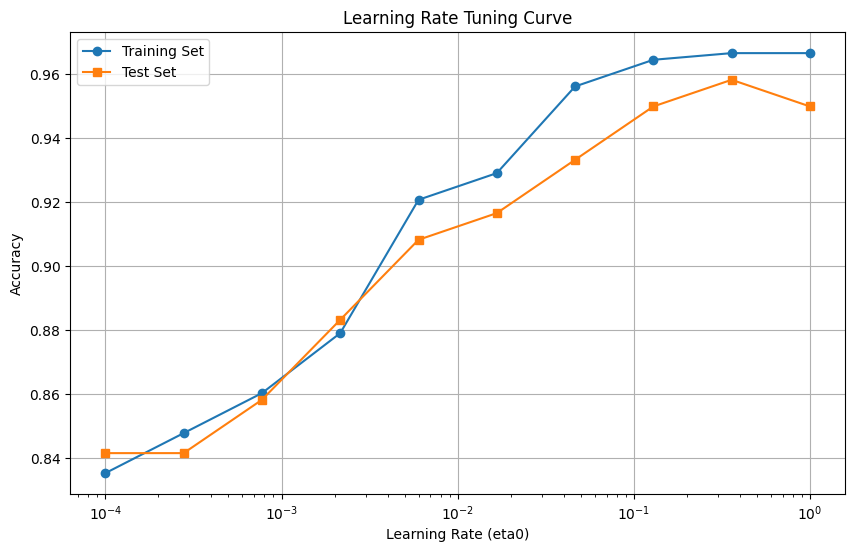

In [33]:
# 固定数据拆分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 测试不同学习率
learning_rates = np.logspace(-4, 0, 10)
train_scores, test_scores = validation_curve(
    make_pipeline(
        StandardScaler(),
        SGDClassifier(
            loss='log_loss',
            learning_rate='constant',
            max_iter=1000,
            random_state=42
        )
    ),
    X_train,
    y_train,
    param_name='sgdclassifier__eta0',
    param_range=learning_rates,
    cv=5
)

# 可视化学习率影响
plt.figure(figsize=(10,6))
plt.semilogx(learning_rates, np.mean(train_scores, axis=1), 'o-', label="Training Set")
plt.semilogx(learning_rates, np.mean(test_scores, axis=1), 's-', label="Test Set")
plt.xlabel('Learning Rate (eta0)')
plt.ylabel('Accuracy')
plt.title('Learning Rate Tuning Curve')
plt.legend()
plt.grid(True)
plt.show()

#3. 最终模型训练与保存

In [34]:
# 选择最佳参数
best_model = make_pipeline(
    StandardScaler(),
    SGDClassifier(
        loss='log_loss',
        learning_rate='constant',
        eta0=0.1,
        max_iter=1000,
        random_state=42
    )
)

best_model.fit(X, y)  # 使用全量数据

# 保存模型参数
dump(best_model, 'iris_sgd_model.joblib')

# 显示模型信息
print("模型保存成功！")
print("输入特征:", datasets.load_iris().feature_names)
print("目标类别:", datasets.load_iris().target_names.tolist())

模型保存成功！
输入特征: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
目标类别: ['setosa', 'versicolor', 'virginica']


#三 训练后模型参数保存到文件，在另一个代码中加载参


In [35]:
# 模型加载与预测示例
import numpy as np
from joblib import load

# 加载保存的模型
model = load('iris_sgd_model.joblib')

# 新样本预测（示例数据）
new_samples = np.array([
    [5.1, 3.5, 1.4, 0.2],   # 预期类别0
    [6.7, 3.0, 5.2, 2.3],   # 预期类别2
    [5.9, 2.8, 4.1, 1.3]    # 预期类别1
])

# 执行预测
probs = model.predict_proba(new_samples)
preds = model.predict(new_samples)

# 获取类别名称
class_names = ['setosa', 'versicolor', 'virginica']

# 输出结果
print("预测结果：")
for i, (prob, pred) in enumerate(zip(probs, preds)):
    print(f"\n样本 {i+1}:")
    print(f"预测类别: {class_names[pred]} ({pred})")
    print("类别概率:")
    for name, p in zip(class_names, prob):
        print(f"  {name}: {p:.4f}")

预测结果：

样本 1:
预测类别: setosa (0)
类别概率:
  setosa: 0.9078
  versicolor: 0.0922
  virginica: 0.0000

样本 2:
预测类别: virginica (2)
类别概率:
  setosa: 0.0001
  versicolor: 0.1462
  virginica: 0.8537

样本 3:
预测类别: versicolor (1)
类别概率:
  setosa: 0.0222
  versicolor: 0.9510
  virginica: 0.0269


# 四 总结逻辑回归运算及训练相关知识点





---
## 一、核心数学原理

### 模型表达式
- **二分类：**
  $$
  P(y=1|\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x} + b) = \frac{1}{1+e^{-(\mathbf{w}^T\mathbf{x} + b)}}
  $$
  （σ为sigmoid函数）

- **多分类（Softmax扩展）：**
  $$
  P(y=k|\mathbf{x}) = \frac{e^{\mathbf{w}_k^T\mathbf{x} + b_k}}{\sum_{j=1}^K e^{\mathbf{w}_j^T\mathbf{x} + b_j}}
  $$

### 损失函数
- **二分类交叉熵损失：**
  $$
  J(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N [y_i\log(p_i) + (1-y_i)\log(1-p_i)]
  $$

- **多分类交叉熵损失：**
  $$
  J(\mathbf{W}) = -\frac{1}{N}\sum_{i=1}^N\sum_{k=1}^K y_{ik}\log(p_{ik})
  $$

- **正则化项：**
  $$
  \lambda |\mathbf{w}|_1 \quad (\text{L1})
  $$
  $$
  \frac{\lambda}{2}|\mathbf{w}|_2^2 \quad (\text{L2})
  $$

### 梯度计算
- **权重梯度：**
  - **L1 正则化：**
    $$
    \frac{\partial J}{\partial \mathbf{w}} = \frac{1}{N}\mathbf{X}^T(\mathbf{p} - \mathbf{y}) + \lambda \cdot \text{sign}(\mathbf{w})
    $$
  - **L2 正则化：**
    $$
    \frac{\partial J}{\partial \mathbf{w}} = \frac{1}{N}\mathbf{X}^T(\mathbf{p} - \mathbf{y}) + \lambda \mathbf{w}
    $$

---

### 二、训练流程
1. **数据预处理**  
   • 标准化（必须）：`StandardScaler`  
   • 特征工程：多项式扩展（`PolynomialFeatures`）、交互项  
   • 处理类别不平衡：`class_weight`参数或SMOTE过采样

2. **优化算法**  
   | 算法 | 适用场景 | Scikit-learn参数 | 特点 |
   |---|---|---|---|
   | L-BFGS | 小数据集 | `solver='lbfgs'` | 二阶收敛快，内存消耗大 |
   | SGD | 大数据集 | `SGDClassifier` | 支持在线学习，需调学习率 |
   | Newton-CG | 中型数据 | `solver='newton-cg'` | 需计算Hessian矩阵 |
   | SAGA | 高维稀疏数据 | `solver='saga'` | 支持L1正则 |

3. **超参数调优**  
   • 正则化强度 `C`（\( C = 1/\lambda \)）：常用对数空间搜索（`np.logspace(-3,3,7)`）
   • 正则化类型：L1（特征选择） vs L2（默认）
   • 学习率（SGD）：`learning_rate='adaptive'`或`eta0`设置初始值
   • 最大迭代次数：`max_iter`配合`tol`早停

---

### 三、高级训练技巧
1. **交叉验证策略**  
   ```python
   GridSearchCV(
       estimator=pipeline,
       param_grid={'clf__C': [0.1, 1, 10], 'clf__penalty': ['l1','l2']},
       cv=StratifiedKFold(n_splits=5),
       scoring='roc_auc'
   )
   ```

2. **学习率动态调整**  
   • 衰减策略：`learning_rate='optimal'`（基于1/(α*(t+t0))）
   • 自定义调度：通过`eta0`和`power_t`控制衰减速度

3. **多分类策略**  
   | 方法 | 适用场景 | 特点 |
   |---|---|---|
   | OvR (One-vs-Rest) | 类别较少 | 训练K个二分类器 |
   | Multinomial | 类别均衡 | 更精确的概率估计 |
   | Softmax | 神经网络基础 | 直接多分类输出 |

---

### 四、模型评估与解释
1. **评估指标**  
   ```python
   print(classification_report(y_test, y_pred, target_names=target_names))
   ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
   ```

2. **特征重要性分析**  
   ```python
   coef = model.named_steps['clf'].coef_
   plt.barh(feature_names, coef[0])
   ```

3. **决策边界可视化**  
   ```python
   Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
   plt.contourf(xx, yy, Z, alpha=0.3)
   ```

---

### 五、生产部署要点
1. **模型持久化**  
   ```python
   from joblib import dump
   dump(pipeline, 'model.joblib')  # 保存完整Pipeline
   ```

2. **预测API示例**  
   ```python
   def predict(input_data):
       scaler = load('scaler.joblib')
       model = load('model.joblib')
       scaled_data = scaler.transform(input_data)
       return model.predict_proba(scaled_data)
   ```

---

### 六、常见问题解决
1. **收敛警告**  
   • 增大`max_iter`  
   • 调整`tol`容差值  
   • 检查特征尺度（必须标准化）

2. **过拟合处理**  
   • 增加正则化强度（减小C值）
   • 添加特征选择步骤
   • 使用Early Stopping

3. **类别预测偏差**  
   • 调整`class_weight`参数
   • 使用SMOTE过采样
   • 改用适合不平衡数据的评估指标（F1、AUC-ROC）

---

通过掌握以上知识点，您将能够：  
• 深入理解逻辑回归的数学本质  
• 熟练进行特征工程与模型调优  
• 有效解决实际分类任务中的各类问题  
• 构建生产级的分类系统